## 5.1. abundances barplot

In this Notebook we will compare the abundances of each cluster in the different response timepoints (3h, 24h, 72h) to the abundance of that same cluster in the control subset. Since each subset consists of four replicates (defined by the hashtags), we can include an error margin. 

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0

# other 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text
from scipy.stats import ttest_ind # for statistical test

### Load dataset

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3).

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

### Calculate abundances
Here, we calculate the abundance of each cluster in each timepoint. We calculate the abundance for every hashtag, and the total abundance is the average of the four different hashtags.

In [3]:
### get timepoints and hashtags
timepoints = adata.obs['time'].cat.categories
hashtags = adata.obs['hashtags'].cat.categories
clusters = adata.obs['clusters'].cat.categories

### create a 3D array with zeros
array_shape = (len(timepoints), len(hashtags), len(clusters))
abundances_array = np.zeros(array_shape, dtype=float)

### get abundance of each tag, in each timepoint, for each cluster (3D matrix)
for time_idx, timepoint in enumerate(timepoints):
    for tag_idx, tag in enumerate(hashtags):
        abund_tag = pd.DataFrame(adata[(adata.obs["hashtags"]==tag)&(adata.obs["time"]==timepoint)].obs["clusters"].value_counts(sort=False))
        abund_tag = abund_tag.div(abund_tag.sum(axis=0), axis=1)*100 #make relative abundance
        abundances_array[time_idx,tag_idx] = abund_tag.values.flatten()
        
### calculate the mean of the abundances along the hashtag axis
mean_abundances = np.mean(abundances_array, axis=1)

### calculate the standard deviation of the abundances along the hashtag axis
std_abundances = np.std(abundances_array, axis=1)

Here, we calculate the p-values using a two-sided t-test.

In [4]:
### calculate the p-values 

# create a 3D array with ones
array_shape = (len(timepoints), len(clusters))
pvalue_abundances = np.ones(array_shape, dtype=float)

for time_idx in range(1, len(timepoints)):

    # iterate over the clusters and calculate the t-test
    for cluster_idx, cluster in enumerate(clusters):
        control_cluster_abundances = abundances_array[0][:, cluster_idx]
        current_cluster_abundances = abundances_array[time_idx][:, cluster_idx]

        # perform the t-test
        _, p_value = ttest_ind(control_cluster_abundances, current_cluster_abundances)
        
        # add pvalue to array
        pvalue_abundances[time_idx][cluster_idx] = p_value

### Plot abundances
Here, we plot the abundances that we retrieved above.

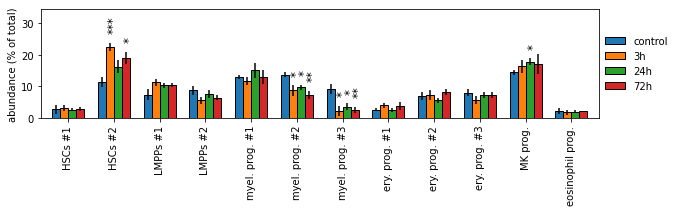

In [6]:
### plot abundances
fig, axs = plt.subplots(1, 1, figsize=(10, 2))

mean_df = pd.DataFrame(mean_abundances, columns=clusters, index=timepoints)
std_df = pd.DataFrame(std_abundances, columns=clusters, index=timepoints)

# create barplot
mean_df.T.plot(kind="bar", yerr=std_abundances, ax=axs, width=0.7, edgecolor="black")
axs.grid(False)

# add legend and labels
axs.set_ylabel("abundance (% of total)")
axs.legend(loc="right", bbox_to_anchor=(1.14, 0.5), ncol=1, frameon=False)
    
# adjust the plot limits to make room for the star annotations
axs.set_ylim([0, mean_abundances.max().max() + 12])

# add star for p-value
for time_idx in range(1, len(timepoints)):
    for cluster_idx, cluster in enumerate(clusters):
        p_value = pvalue_abundances[time_idx, cluster_idx]
        if p_value < 0.0001:
            star_y = mean_df.iloc[time_idx, cluster_idx] + std_df.iloc[time_idx, cluster_idx] + 4
            axs.text(axs.patches[cluster_idx + time_idx*len(clusters)].get_x() + 0.02, star_y, "***", fontsize=12, rotation = 90)
        elif p_value < 0.001:
            star_y = mean_df.iloc[time_idx, cluster_idx] + std_df.iloc[time_idx, cluster_idx] + 4
            axs.text(axs.patches[cluster_idx + time_idx*len(clusters)].get_x() + 0.02, star_y, "**", fontsize=12, rotation = 90)
        elif p_value < 0.01:
            star_y = mean_df.iloc[time_idx, cluster_idx] + std_df.iloc[time_idx, cluster_idx] + 4
            axs.text(axs.patches[cluster_idx + time_idx*len(clusters)].get_x() + 0.02, star_y, "*", fontsize=12, rotation = 90)

# save figure
save_path = "../figures/5.1.abundances_barplot.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

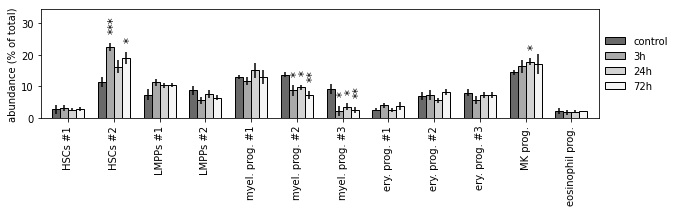

In [7]:
### plot abundances
fig, axs = plt.subplots(1, 1, figsize=(10, 2))

mean_df = pd.DataFrame(mean_abundances, columns=clusters, index=timepoints)
std_df = pd.DataFrame(std_abundances, columns=clusters, index=timepoints)

# create barplot
mean_df.T.plot(kind="bar", yerr=std_abundances, ax=axs, width=0.7, 
                     color=['dimgray', 'darkgray', 'lightgray', 'whitesmoke'], edgecolor="black")
axs.grid(False)

# add legend and labels
axs.set_ylabel("abundance (% of total)")
axs.legend(loc="right", bbox_to_anchor=(1.14, 0.5), ncol=1, frameon=False)
    
# adjust the plot limits to make room for the star annotations
axs.set_ylim([0, mean_abundances.max().max() + 12])

# add star for p-value
for time_idx in range(1, len(timepoints)):
    for cluster_idx, cluster in enumerate(clusters):
        p_value = pvalue_abundances[time_idx, cluster_idx]
        if p_value < 0.0001:
            star_y = mean_df.iloc[time_idx, cluster_idx] + std_df.iloc[time_idx, cluster_idx] + 4
            axs.text(axs.patches[cluster_idx + time_idx*len(clusters)].get_x() + 0.02, star_y, "***", fontsize=12, rotation = 90)
        elif p_value < 0.001:
            star_y = mean_df.iloc[time_idx, cluster_idx] + std_df.iloc[time_idx, cluster_idx] + 4
            axs.text(axs.patches[cluster_idx + time_idx*len(clusters)].get_x() + 0.02, star_y, "**", fontsize=12, rotation = 90)
        elif p_value < 0.01:
            star_y = mean_df.iloc[time_idx, cluster_idx] + std_df.iloc[time_idx, cluster_idx] + 4
            axs.text(axs.patches[cluster_idx + time_idx*len(clusters)].get_x() + 0.02, star_y, "*", fontsize=12, rotation = 90)

# save figure
save_path = "../figures/5.1.abundances_barplot_graytones.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()